# Projet RI-Web par Cécile Gontier et Delphine Shi
Ce notebook va faire calculer les résultats principaux du projet, il est possible de voir le code directement pour plus de précisions.
Nous avons laissé les outputs pour ne pas obliger à tout runner, ce qui peut être très long pour certaines exécutions.
Note : si les figures ne s'affichent pas correctement, il suffit de runner une deuxième fois.

## Partie 1 : Pre-processing du corpus
Dans cette partie, on calcule le vocabulaire et le nombre de tokens de chaque collection, on calcule sa loi de Heap et on affiche son graphe de rang-fréquence.

Les résultats sont récapitulés dans ce tableau :

| Mesure | CACM | CS276 |
| ----- | ----- | ----- |
| Nombre de tokens | 188 887 | 25 527 977 |
| Taille du vocabulaire | 9 238 | 284 418 |
| Tokens sur moitié de la collection | 85 151 | 12 796 571 |
| Vocab sur moitié de la collection | 6 334 | 140 665 |
| Loi de Heap | b = 0.474    k = 29.264 | b = 1.019    k = 0.00798 |
| Estimation taille du vocabulaire (1M de tokens) | 20 343 | 10 459 |

On peut les recalculer avec les lignes suivantes.

### CACM
Calcule le vocabulaire et le nombre de tokens de chaque collection, on calcule sa loi de Heap et on affiche son graphe de rang-fréquence.

Tokens: 188887
Vocabulary: 9238

For half of the text:
Tokens: 85151
Vocabulary: 6334

The Heap law parameters are:
(b, k) = (0.4736822683077262, 29.264061028536908)
For 1 million tokens there would be (by Heap law) 20343.618531559812 words in the vocabulary


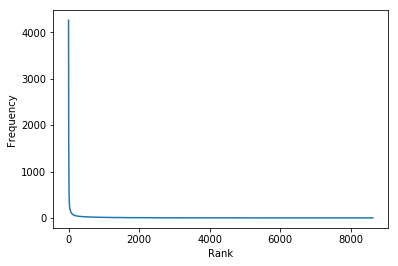

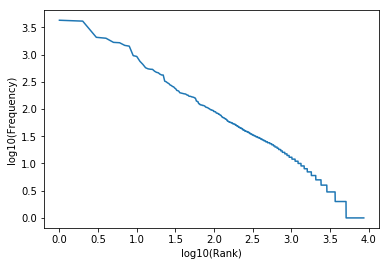

In [2]:
from CACMIndex import *
from heapRegression import *

cacm_index = CACMIndex()
cacm_index.build()
nb_tokens, nb_vocab = cacm_index.get_size()
# nb_tokens, nb_vocab = 188887, 9238

print()
print("For half of the text:")
cacm_index.build(half=True)
nb_tokens_half, nb_vocab_half = cacm_index.get_size()
# nb_tokens_half, nb_vocab_half = 85151, 6334

print()
CACM_tokens = np.array([nb_tokens, nb_tokens_half])
CACM_vocab = np.array([nb_vocab, nb_vocab_half])
heap = HeapRegression(CACM_tokens, CACM_vocab)
parameters = heap.calculate_regression()
print("The Heap law parameters are:")
print("(b, k) = {}".format(parameters))
print("For 1 million tokens there would be (by Heap law) {} words in the vocabulary"
    .format(heap.calculate_vocab(1000000)))

graph = FrequencyRankGraph(cacm_index.get_freq())
graph.draw_graph()
graph.draw_log_graph()

### CS276
Calcule le vocabulaire et le nombre de tokens de chaque collection, on calcule sa loi de Heap et on affiche son graphe de rang-fréquence. (La construction de l'index CS276 prend environ 10 min donc la regénération de ces chiffres prendra environ 20 min.)

In [1]:
from CS276Index import *
from heapRegression import *

cs276_index = CS276Index()
cs276_index.build()
nb_tokens, nb_vocab = cs276_index.get_size()
# nb_tokens, nb_vocab = 25527977, 284418

print()
print("For half of the text:")
cs276_index.build(half=True)
nb_tokens_half, nb_vocab_half = cs276_index.get_size()
# nb_tokens_half, nb_vocab_half = 12796571, 140665

print()
CS276_tokens = np.array([nb_tokens,  nb_tokens_half])
CS276_vocab = np.array([nb_vocab, nb_vocab_half])
heap = HeapRegression(CS276_tokens, CS276_vocab)
parameters = heap.calculate_regression()
print("The Heap law parameters are:")
print("(b, k) = {}".format(parameters))
print("For 1 million tokens there would be (by Heap law) {} vocabulary"
    .format(heap.calculate_vocab(1000000)))

graph = FrequencyRankGraph(cs276_index.get_freq())
graph.draw_graph()
graph.draw_log_graph()

2019-03-09 12:21:05,632 - INFO : Read 1/10 folders
2019-03-09 12:21:10,450 - INFO : Read 2/10 folders
2019-03-09 12:21:14,569 - INFO : Read 3/10 folders
2019-03-09 12:21:19,299 - INFO : Read 4/10 folders
2019-03-09 12:21:23,844 - INFO : Read 5/10 folders
2019-03-09 12:21:28,496 - INFO : Read 6/10 folders
2019-03-09 12:21:33,007 - INFO : Read 7/10 folders
2019-03-09 12:21:37,679 - INFO : Read 8/10 folders
2019-03-09 12:21:42,448 - INFO : Read 9/10 folders
2019-03-09 12:21:46,679 - INFO : Read 10/10 folders


Tokens: 25527977
Vocabulary: 284418

For half of the text:


2019-03-09 12:29:14,511 - INFO : Read 1/10 folders
2019-03-09 12:29:19,987 - INFO : Read 2/10 folders
2019-03-09 12:29:25,496 - INFO : Read 3/10 folders
2019-03-09 12:29:31,221 - INFO : Read 4/10 folders
2019-03-09 12:29:36,271 - INFO : Read 5/10 folders
2019-03-09 12:29:41,153 - INFO : Read 6/10 folders
2019-03-09 12:29:46,261 - INFO : Read 7/10 folders
2019-03-09 12:29:51,512 - INFO : Read 8/10 folders
2019-03-09 12:29:57,191 - INFO : Read 9/10 folders
2019-03-09 12:30:02,027 - INFO : Read 10/10 folders


Tokens: 12758945
Vocabulary: 144002

The Heap law parameters are:
(b, k) = (0.9813643763154826, 0.015309994988403103)
For 1 million tokens there would be (by Heap law) 11834.810447358743 vocabulary


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

## Partie 2 : Index inversé
On crée directement l'index inversé avec les fréquences. Le json est de la forme :

$\{term_{id} : [[doc_{id}, frequency], [doc_{id}, frequency], ...], ...\}$

On construit l'index par la méthode BSBI (block sort-based index) :
1. On commence par créer un dictionnaire de termes de la forme : $\{term : term_{id}\}$
et un dictionnaire de documents de la forme : $\{doc_{id} : doc\}$.
2. On va ensuite segmenter la collection en blocs : la collection CACM est considérée comme un seul bloc. Pour CS276, on considère chaque sous-répertoire comme bloc.
3. Pour chaque bloc, on parcourt les documents du bloc afin de définir les paires $\{term_{id} : [doc_{id}, frequency]\}$ indiquant dans quels documents chaque terme du vocabulaire apparaît. On peut ensuite trier les paires selon $term_{id}$ puis $doc_{id}$ afin d'obtenir des objets de la forme : $\{term_{id} : [[doc_{id}, frequency], ...]\}$
4. On stocke les résultats intermédiaires sur le disque.
5. On répète le processus jusqu'au parcours complet de la collection.
6. Enfin, on fusionne tous les résultats pour obtenir l'index final.

Dans notre projet, le fichier `BSBI.py` est le point d'entrée de la construction de l'index. On va récupérer le dictionnaire de termes et segmenter la collection en blocs puis appliquer les fonctions de `BSBIndex.py` sur chaque bloc pour en construire les index. Enfin, on fusionne les différents indexes créés.

@Nous : ajouter un tableau avec la taille des index.

### CACM
Construction et sauvegarde de l'index CACM. Cela le sauvegarde dans le dossier `index\`.

In [3]:
from BSBI import *

index = BSBI('CACM')
index.build()

2019-03-09 14:53:58,647 - INFO : Building inverted index...
2019-03-09 14:53:59,855 - INFO : Built block 0 index
2019-03-09 14:53:59,856 - INFO : Merging intermediate results...
2019-03-09 14:54:00,301 - INFO : Finished building inverted index.


### CS276
Construction et sauvegarde de l'index CS276. Il faut en général 30 min mais cela peut prendre jusqu'à une heure à cause de sa taille. Vous pouvez aussi envoyer un mail à Cécile ou Delphine pour avoir l'index en fichier zippé et l'ajouter au dossier `index/`.

In [2]:
from BSBI import *

CS276index = BSBI('CS276')
CS276index.build()

2019-03-09 12:53:58,788 - INFO : Read 1/10 folders
2019-03-09 12:54:04,170 - INFO : Read 2/10 folders
2019-03-09 12:54:09,311 - INFO : Read 3/10 folders
2019-03-09 12:54:14,643 - INFO : Read 4/10 folders
2019-03-09 12:54:19,241 - INFO : Read 5/10 folders
2019-03-09 12:54:23,863 - INFO : Read 6/10 folders
2019-03-09 12:54:27,548 - INFO : Read 7/10 folders
2019-03-09 12:54:32,991 - INFO : Read 8/10 folders
2019-03-09 12:54:38,283 - INFO : Read 9/10 folders
2019-03-09 12:54:43,311 - INFO : Read 10/10 folders
2019-03-09 13:01:30,027 - INFO : Building inverted index...
2019-03-09 13:03:56,755 - INFO : Built block 0 index
2019-03-09 13:06:13,223 - INFO : Built block 1 index
2019-03-09 13:08:37,869 - INFO : Built block 2 index
2019-03-09 13:10:22,858 - INFO : Built block 3 index
2019-03-09 13:12:10,890 - INFO : Built block 4 index
2019-03-09 13:13:53,699 - INFO : Built block 5 index
2019-03-09 13:15:19,729 - INFO : Built block 6 index
2019-03-09 13:16:31,242 - INFO : Built block 7 index
2019-

## Part 3 : Recherche
Ici on utilise les index créés précedemment pour effectuer des recherches simples.

### Recherche booléenne
Pour modéliser une recherche booléenne nous avons utilisé la structure `BooleanRequest(operateur, opérande_gauche, opérande_droit)`, qui s'inspire de la notation polonaise.

#### Collection CACM
Il faut avoir sauvegardé l'index précédemment.

In [6]:
from boolean.booleanEvaluation import *

# search for documents having words arithmetic and hardware in CACM collection
request_and = BooleanRequest(Operation.AND, "arithmetic", "hardware")  # 1258, 1409, 2175, 3131
model = BooleanEvaluation(request_and, "CACM")
res, total = model.search(rank=5)
model.display_results(res, total)


[1258, 1409, 2175, 3131]
1258
An Extended Arithmetic Package In many fields, for example algebraic number
theory, arithmetic must be carried out to a degree 
of precision which exceeds the normal hardware capacity
of most machines.  In such cases, an extended 
arithmetic package provides a comprehensive and easy-to-use
way of performing such arithmetic.  Such 
a package was coded for the IBM 7090.  In discussing
the general problems associated with the design 
of an extended arithmetic package, specific reference is made to this program.


1409
NEBULA: A Digital Computer Using a 20 Mc Glass Delay Line Memory Oregon State University has designed and constructed
a medium-speed serial digital computer 
using glass delay lines circulating at 22 Mc as memory.
 The design objectives as originally conceived 
in a special seminar were: (1) to be a research project
in computer design; (2) to be usable as an educational 
machine;and (3) to have easily modifiable hardware for
basic research in co

#### Collection CS276
Il faut avoir sauvegardé l'index précédemment dans le dossier `index`.

In [5]:
from boolean.booleanEvaluation import *

# This will take a few minutes as we need to load the index in memory
request_and = BooleanRequest(Operation.AND, "data", "process")
model = BooleanEvaluation(request_and, "CS276")
res, total = model.search(rank=5)
model.display_results(res, total)

0-101
aaa lab at stanford child development and learning external representations social mediation transfer learning versus development dynamic assessment actions and symbols earlier forms of knowledge neuroscience and education daniel schwartz kristen pilner jessica tsang julie heiser taylor martin bruce mccandliss sashank varma physically distributed learning adapting and reinterpreting physical environments in the development of the fraction concept cognitive science how should educational neuroscience conceptualize the relation between cognition and brain function mathematical reasoning as a network process educational research young children's understanding of animacy and entertainment robots international journal of humanoid robotics scientific and pragmatic challenges for bridging education and neuroscience educational researcher reconsidering prior knowledge in thinking with data fostering mathematical thinking in middle school students lessons from research in the nature of ma

### Recherche vectorielle
Dans la recherche vectorielle, la requête est une un string avec des mots dedans. On preprocesse ce string pour en extraire le vocabulaire (de la même manière que les collections elles-même).

@Delphine : expliquer qu'on a défini plusieurs weighting et mesures.

#### Collection CACM
Il faut avoir sauvegardé l'index précédemment dans le dossier `index`.

In [7]:
from vectorial.vectorialEvaluation import *

# in CACM collection
logging.info("Start search...")
cacm_request = "arithmetic hardware"
model = VectorialEvaluation(cacm_request, "CACM")
# results, total = model.search(NaturalWeighting(), rank=5)
# results, total = model.search(TfIdfWeighting(), rank=5)
results, total = model.search(NormalizedTfIdfWeighting(), "jaccard", rank=5)
# print(results)
model.display_results(results, total)
logging.info("Results retrieved.")

2019-03-07 14:52:28,636 - INFO : Start search...
2019-03-07 14:52:29,060 - INFO : Results retrieved.


1409
NEBULA: A Digital Computer Using a 20 Mc Glass Delay Line Memory Oregon State University has designed and constructed
a medium-speed serial digital computer 
using glass delay lines circulating at 22 Mc as memory.
 The design objectives as originally conceived 
in a special seminar were: (1) to be a research project
in computer design; (2) to be usable as an educational 
machine;and (3) to have easily modifiable hardware for
basic research in computer systems design.  An 
unusual arrangement of information within the 22 Mc
memory allows a simple interface with the 340 Kc 
arithmetic unit, which results in an effective zero latency
time and provides possibilities for an associative 
memory.  The arithmetic unit has a command structure similar
to large parallel machines, and uses flip-flop 
arithmetic and control registers throughout.  All hardware
development has been aimed toward the concept 
of easy modification, elaborate console controls for
effective man-machine interaction an

#### Collection CS276
Il faut avoir sauvegardé l'index précédemment dans le dossier `index`.

In [8]:
# This will take a few minutes as we need to load the index in memory.
logging.info("Start search...")
cs276_request = "data processing high res calibration"
model = VectorialEvaluation(cs276_request, "CS276")
# results, total = model.search(NaturalWeighting(), rank=5)
# results, total = model.search(TfIdfWeighting(), rank=5)
results, total = model.search(NormalizedTfIdfWeighting(), "jaccard", rank=5)
model.display_results(results, total)
logging.info("Results retrieved.")

2019-03-07 14:52:47,131 - INFO : Start search...
2019-03-07 15:02:02,889 - INFO : Results retrieved.


2-4486
wide area camera calibration using virtual calibration objects page 1 comparison with traditional calibration wide area camera calibration using virtual calibration objects xing chen james davis philipp slusallek goal calibrate many cameras arranged to cover a wide area working volume building a large physical calibration object is impractical solution build a large virtual calibration object that covers the entire working volume method use all cameras to observe a moving object iterate between solving for the object path and using this path as a virtual calibration object to solve for camera position a space in which a comparison with traditional calibration is possible projection error of a moving object note that the quality of the calibration obtained using our method compares favorably with traditional calibration methods traditional calibration virtual calibration object initial one iteration five iterations results camera arrangement to be calibrated note that since the c

## Part 4 : CACM Evaluation
Dans cette partie on veut évaluer les performances et la pertinence des résultats par la collection CACM.

###  Performance

In [3]:
from CACMEvaluation import *

print("The index is created in {}".format(index_creation_time()))
print("The index CACM has a size {}".format(get_file_size("index_CACM.json")))
# print("The index CS276 has a size {}".format(get_file_size("index_CS276.json")))
print("A boolean request gives a response in {}s".format(get_boolean_response_time()))
print("A vectorial request gives a response in {}s".format(get_vectorial_response_time()))

The index is created in 2.1441550254821777
The index CACM has a size 1M
A boolean request gives a response in 0.00014209747314453125s
A vectorial request gives a response in 0.05024886131286621s


### Pertinence
Pour calculer la pertinence on utilise les requêtes et résultats attendus des fichiers `query.txt` et `qrels.txt`. On trace la courbe de rappel-précision ainsi que les courbes de la F et E mesure. On calcule la précision moyenne puis on calcule la r-précision pour chaque requête.

Plotting recall-precision curve...


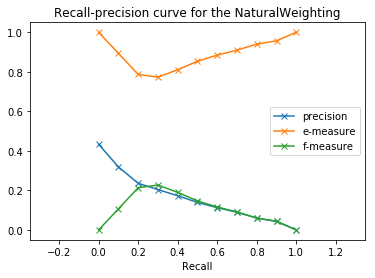

Recall-precision curve plotted

The Mean Average Precision is 0.22270412724117739

Calculate r-precision for all requests...
For the request 1 the r-precision is 0.0.
For the request 2 the r-precision is 0.0.
For the request 3 the r-precision is 0.0.
For the request 4 the r-precision is 0.16666666666666666.
For the request 5 the r-precision is 0.125.
For the request 6 the r-precision is 0.6666666666666666.
For the request 7 the r-precision is 0.07142857142857142.
For the request 8 the r-precision is 0.3333333333333333.
For the request 9 the r-precision is 0.3333333333333333.
For the request 10 the r-precision is 0.4.
For the request 11 the r-precision is 0.47368421052631576.
For the request 12 the r-precision is 0.2.
For the request 13 the r-precision is 0.09090909090909091.
For the request 14 the r-precision is 0.1590909090909091.
For the request 15 the r-precision is 0.0.
For the request 16 the r-precision is 0.11764705882352941.
For the request 17 the r-precision is 0.125.
For the r

In [2]:
from CACMEvaluation import *

# Here you can change the weighting
calculate_measures(NaturalWeighting())